In [13]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

In [14]:
# define a wave function parameters here
# --------------------------------------------------------
def f_x(x):
    # define initial displacement function
    return x * (50 - x) / 2500  # Example from the textbook

c = 5.0  # Wave speed
n_terms = 10  # Number of terms in the Fourier series

In [15]:
# Analytical solution function to compare the NN results 
def analytical_solution(x, t, n_terms): # this analytical solution was taken from the textbook
    u = torch.zeros_like(x)
    for n in range(1, n_terms + 1, 2):  # Only odd n
        term = (8 / (np.pi**3)) * (1 / (n**3)) * torch.sin(n * np.pi * x / 50) * torch.cos(n * np.pi * t / (50 / c))
        u += term
    return u

In [16]:
# Define the initial conditions
def initial_displacement(x):
    return f_x(x)

def initial_velocity(x):
    return torch.zeros_like(x)

In [17]:
# Physics-informed loss for the wave equation
def wave_equation_residual(model, x, t, c):
    x.requires_grad_(True)
    t.requires_grad_(True)
    u = model(x, t)
    u_t = torch.autograd.grad(u, t, grad_outputs=torch.ones_like(u), retain_graph=True, create_graph=True)[0]
    u_tt = torch.autograd.grad(u_t, t, grad_outputs=torch.ones_like(u_t), retain_graph=True, create_graph=True)[0]
    u_x = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), retain_graph=True, create_graph=True)[0]
    u_xx = torch.autograd.grad(u_x, x, grad_outputs=torch.ones_like(u_x), retain_graph=True, create_graph=True)[0]
    residual = u_tt - (c**2) * u_xx
    return residual

In [18]:
def boundary_conditions(model, t):
    t.requires_grad_(True) # for some reason requires to be established twice
    x_left = torch.zeros_like(t) # values taken from the textbook
    x_right = torch.ones_like(t) * 50 # values taken from the textbook
    u_left = model(x_left, t)
    u_right = model(x_right, t)
    return torch.mean(u_left ** 2) + torch.mean(u_right ** 2)

In [19]:
def initial_condition_loss(model, x):
    x.requires_grad_(True)
    t_init = torch.zeros_like(x, requires_grad=True)  # t=0
    u_init = initial_displacement(x)
    u_pred = model(x, t_init)
    loss_disp = torch.mean((u_pred - u_init) ** 2)

    u_init_velocity = initial_velocity(x)
    u_t = torch.autograd.grad(u_pred, t_init, grad_outputs=torch.ones_like(u_pred), retain_graph=True, create_graph=True)[0]
    loss_vel = torch.mean((u_t - u_init_velocity) ** 2)
    return loss_disp + loss_vel

In [21]:
class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(2, 100),  # Input: (x, t)
            nn.Tanh(),
            nn.Linear(100, 100),
            nn.Tanh(),
            nn.Linear(100, 100),
            nn.Tanh(),
            nn.Linear(100, 1)   # Output: u(x, t)
        )
    
    def forward(self, x, t):
        inputs = torch.cat([x, t], dim=1)
        return self.net(inputs)

In [23]:
# Train the model with tracking
def train_pinn_with_tracking(model, optimizer, n_epochs=1000, n_points=100):
    loss_history = []
    for epoch in range(n_epochs):
        x = torch.rand((n_points, 1), dtype=torch.float32) * 50
        t = torch.rand((n_points, 1), dtype=torch.float32) * 1
        residual = wave_equation_residual(model, x, t, c)
        loss_pde = torch.mean(residual ** 2)
        x_init = torch.linspace(0, 50, n_points).reshape(-1, 1)
        loss_ic = initial_condition_loss(model, x_init)
        t_bound = torch.linspace(0, 1, n_points).reshape(-1, 1)
        loss_bc = boundary_conditions(model, t_bound)
        loss = loss_pde + loss_ic + loss_bc
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_history.append(loss.item())
        if epoch % 1000 == 0:
            print(f"Epoch {epoch}, Loss: {loss.item():.6f}")
    return loss_history

In [24]:
# Initialize and train the model
model = PINN()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_history = train_pinn_with_tracking(model, optimizer)

Epoch 0, Loss: 0.051204
Epoch 1000, Loss: 0.000130
Epoch 2000, Loss: 0.000092
Epoch 3000, Loss: 0.000066
Epoch 4000, Loss: 0.000125


In [25]:
# Visualization and comparison
x_vals = torch.linspace(0, 50, 100).reshape(-1, 1)
t_vals = 0.5
t_fixed = torch.full_like(x_vals, t_vals)
u_pinn = model(x_vals, t_fixed).detach().numpy().flatten()
u_analytical = analytical_solution(x_vals, t_fixed, n_terms).numpy().flatten()


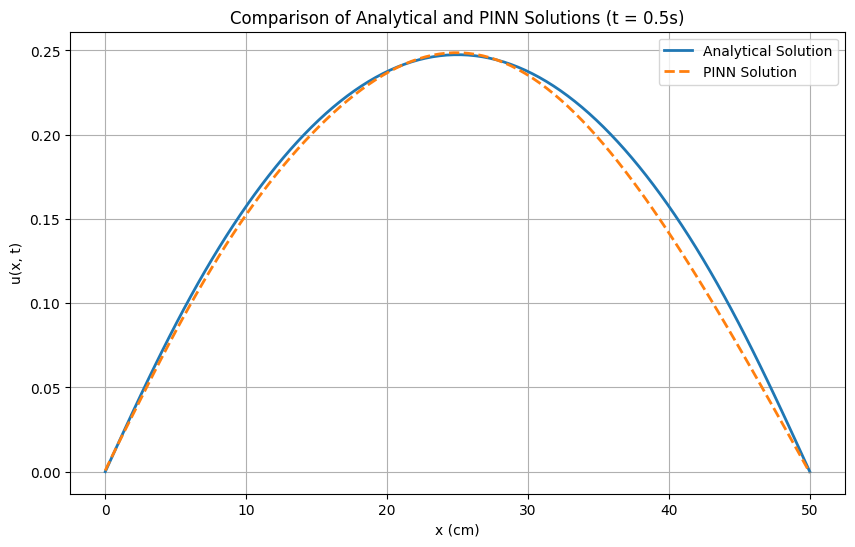

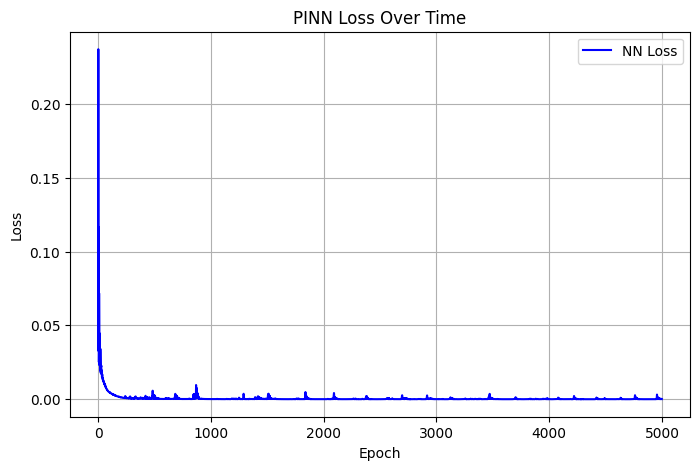

In [26]:
# Plotting
plt.figure(figsize=(10, 6))
plt.plot(x_vals.numpy().flatten(), u_analytical, label="Analytical Solution", linewidth=2)
plt.plot(x_vals.numpy().flatten(), u_pinn, label="PINN Solution", linestyle="dashed", linewidth=2)
plt.xlabel("x (cm)")
plt.ylabel("u(x, t)")
plt.title(f"Comparison of Analytical and PINN Solutions (t = {t_vals}s)")
plt.legend()
plt.grid(True)
plt.show()

# Plot NN Loss
plt.figure(figsize=(8, 5))
plt.plot(loss_history, label="NN Loss", color="blue")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("PINN Loss Over Time")
plt.legend()
plt.grid(True)
plt.show()

In [27]:
# Maximum difference
max_difference = np.max(np.abs(u_pinn - u_analytical))
print(f"Maximum Difference between PINN and Analytical Solution: {max_difference:.6f}")

Maximum Difference between PINN and Analytical Solution: 0.016445
